In [1]:
import re

t = """
// Comments
0: atomicstage = "start_m"
1: atomicstage = "end_m" // Comments
2: atomicstage = "start_a"
3: atomicstage = "end_aok"
4: atomicstage = "start_p"
5: atomicstage = "start_m"
6: atomicstage = "end_p"
7: atomicstage = "end_m"
8: atomicstage = "start_a"
9: atomicstage = "end_a"
10: atomicstage = "start_l"
11: atomicstage = "end_l"
12: atomicstage = "start_e"
13: atomicstage = "end_e"
"""

COMMENT = r'//.*'
MAYBE_COMMENT = f'({COMMENT})?'
WHITESPACE = r'\s*'
INDEX = r'(\d+)'
SEP = ':'
STREAM = r'([a-zA-Z]+)'
EQ = '='
VAL = r'((true|false)|(\d+)|"(.*)")'


def join_pattern(*tokens):
    pattern = WHITESPACE
    for tok in tokens:
        pattern += tok + WHITESPACE
    return pattern


def parse(inp:str):
    lines = inp.split('\n')
    idx = None
    steps = {}

    for line in lines:
        m = re.match(join_pattern(COMMENT) + r'|\s*$', line)
        if m:
            continue
        
        m = re.match(join_pattern(INDEX, SEP, STREAM, EQ, VAL), line)
        if m:
            idx, stream, raw_val,val_bool,val_int,val_str = m.groups()
            idx = int(idx)

            if idx not in steps:
                steps[idx] = dict()
        else:
            m = re.match(join_pattern(STREAM, EQ, VAL), line)
            if m:
                stream, raw_val,val_bool,val_int,val_str = m.groups()
            
            else:
                raise Exception('Bad line: ', line)
                
        match (val_int, val_bool, val_str):
            case (int() as i, None, None):
                val = int(i)
            case (None, str() as b, None):
                val = b == "true"
            case (None, None, str() as s):
                val = s
            case _:
                val = raw_val

        steps[idx][stream] = val

    return steps



In [2]:
def format_atomic(parsed:dict):
    stages = {}
    for step, streams in parsed.items():
        val = streams.get('atomicstage')
        if val is None:
            raise Exception ('Missing stage in step', step)
        m = re.fullmatch(r'(start|end)_([maple])(.*)?', val)
        if m is None:
            raise Exception ('Stage not matching:',val)
        lifecycle, stage, extra = m.groups()
        if stage not in stages:
            stages[stage] = []
        stages[stage].append((step, lifecycle, extra))
    
    return stages


In [3]:
def chain(initial_value, *funcs):
    v = initial_value
    for func in funcs:
        v = func(v)
        print(v)
    
    return v

In [4]:
chain(t,
      parse,
      format_atomic
)


{0: {'atomicstage': 'start_m'}, 1: {'atomicstage': 'end_m'}, 2: {'atomicstage': 'start_a'}, 3: {'atomicstage': 'end_aok'}, 4: {'atomicstage': 'start_p'}, 5: {'atomicstage': 'start_m'}, 6: {'atomicstage': 'end_p'}, 7: {'atomicstage': 'end_m'}, 8: {'atomicstage': 'start_a'}, 9: {'atomicstage': 'end_a'}, 10: {'atomicstage': 'start_l'}, 11: {'atomicstage': 'end_l'}, 12: {'atomicstage': 'start_e'}, 13: {'atomicstage': 'end_e'}}
{'m': [(0, 'start', ''), (1, 'end', ''), (5, 'start', ''), (7, 'end', '')], 'a': [(2, 'start', ''), (3, 'end', 'ok'), (8, 'start', ''), (9, 'end', '')], 'p': [(4, 'start', ''), (6, 'end', '')], 'l': [(10, 'start', ''), (11, 'end', '')], 'e': [(12, 'start', ''), (13, 'end', '')]}


{'m': [(0, 'start', ''), (1, 'end', ''), (5, 'start', ''), (7, 'end', '')],
 'a': [(2, 'start', ''), (3, 'end', 'ok'), (8, 'start', ''), (9, 'end', '')],
 'p': [(4, 'start', ''), (6, 'end', '')],
 'l': [(10, 'start', ''), (11, 'end', '')],
 'e': [(12, 'start', ''), (13, 'end', '')]}

{0: {'atomicstage': 'start_m'}, 1: {'atomicstage': 'end_m'}, 2: {'atomicstage': 'start_a'}, 3: {'atomicstage': 'end_aok'}, 4: {'atomicstage': 'start_p'}, 5: {'atomicstage': 'start_m'}, 6: {'atomicstage': 'end_p'}, 7: {'atomicstage': 'end_m'}, 8: {'atomicstage': 'start_a'}, 9: {'atomicstage': 'end_a'}, 10: {'atomicstage': 'start_l'}, 11: {'atomicstage': 'end_l'}, 12: {'atomicstage': 'start_e'}, 13: {'atomicstage': 'end_e'}}
{'m': [(0, 'start', ''), (1, 'end', ''), (5, 'start', ''), (7, 'end', '')], 'a': [(2, 'start', ''), (3, 'end', 'ok'), (8, 'start', ''), (9, 'end', '')], 'p': [(4, 'start', ''), (6, 'end', '')], 'l': [(10, 'start', ''), (11, 'end', '')], 'e': [(12, 'start', ''), (13, 'end', '')]}
(<Figure size 1600x600 with 1 Axes>, <Axes: >)


(<Figure size 1600x600 with 1 Axes>, <Axes: >)

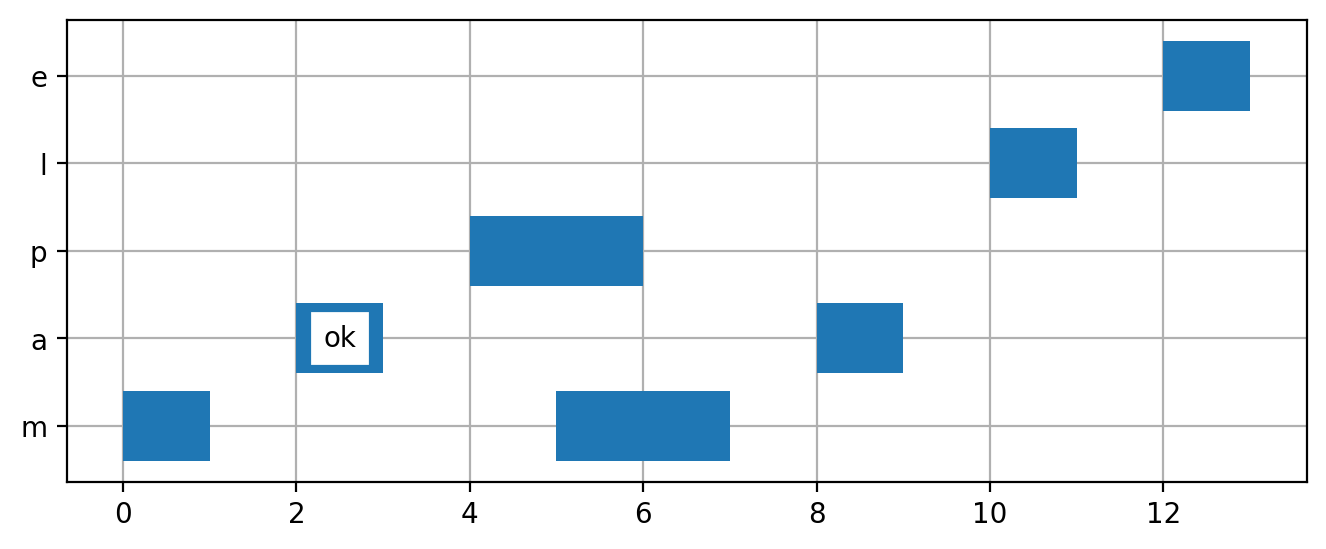

In [12]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

    

def plot_maple_stages(data):
    def create_boxes(data:list[tuple[int,str,str]]):
        boxes:list[tuple[int,int,str]] = []
        starts = []
        for step,lifecycle,extra in data:
            match lifecycle:
                case 'start':
                    starts.append((step, extra))
                case 'end':
                    start_step, start_extra = starts.pop()
                    if start_extra:
                        extra = start_extra + ',' + extra
                    boxes.append((start_step, step, extra))
        # TODO: Handle cases without matching start and end
        return boxes
    
    categories = {
        'm': 0,
        'a': 1,
        'p': 2,
        'l': 3,
        'e': 4
    }

    verts = []
    labels = []

    for k,v in data.items():
        y = categories[k]

        for xfrom,xto,text in create_boxes(v):
            v = [
                (xfrom, y-.4),
                (xfrom, y+.4),
                (xto, y+.4),
                (xto, y-.4),
                (xfrom, y-.4),
            ]
            labels.append(((xfrom+xto)/2, y, text))
            verts.append(v)

    bars = PolyCollection(verts, zorder=3)

    fig, ax = plt.subplots(figsize=[8,3], dpi=200)
    for label in labels:
        ax.text(*label, zorder=5, color='black', backgroundcolor='white', fontsize=10, va='center', ha='center')
    ax.grid(zorder=0)
    ax.add_collection(bars)
    ax.autoscale()

    ax.set_yticks(list(categories.values()))
    ax.set_yticklabels(list((categories.keys())))

    return fig, ax


chain(t,
      parse,
      format_atomic,
      plot_maple_stages
)
